In [4]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

def load_data(dataset, DATA_DIR='./data/'):
    read_args = {
        'node_information':{
            'names': ['id', 'publication_date', 'title', 'authors', 'journal', 'abstract'],
            'index_col': 'id'
        },
        'train': {
            'names': ['source_id', 'target_id','category'],
            'sep': ' ',
        },
        'test':{
            'names':['source_id', 'target_id'],
            'sep': ' ',
        }
    }
    filenames = {
        'node_information': 'node_information.csv',
        'train': 'training_set.txt',
        'test': 'testing_set.txt'
    }
    if dataset in read_args:
        file_path = os.path.join(DATA_DIR, filenames[dataset])
        return pd.read_csv(file_path, header=None, **read_args[dataset])

# Train analysis

In [5]:
train = load_data('train', data_dir='../data')

###### Dataset size

In [5]:
train.shape

(615512, 3)

###### Columns

In [6]:
train.columns

Index(['source_id', 'target_id', 'category'], dtype='object')

###### Distinct source

In [7]:
train['source_id'].drop_duplicates().count()

27770

###### Distinct target

In [8]:
train['target_id'].drop_duplicates().count()

27770

###### Distinct ids

In [9]:
train.source_id.append(train.target_id).drop_duplicates().count()

27770

###### Label repartition

In [10]:
train.category.value_counts()

1    335130
0    280382
Name: category, dtype: int64

In [ ]:
edges = list(tuple(x) for x in train[train.category == 1].drop(columns='category').values.reshape((-1,2)))

In [12]:
import igraph

In [25]:
# We need to map nodes id to [0, number of nodes]
distinct_nodes = sorted(set(train.source_id.drop_duplicates().values))
nodes_mapping = {node:i for i,node in enumerate(distinct_nodes)}
mapped_edges = [(nodes_mapping[_in], nodes_mapping[_out]) for _in, _out in edges]

train_graph = igraph.Graph(mapped_edges)

In [29]:
train_graph = graph

# Graph analysis of train set

###### Number of nodes

In [28]:
graph.vcount()

27770

###### Number of edges

In [90]:
graph.ecount()

335130

###### Number of components

In [33]:
components = graph.components()

In [34]:
len(components)

239

###### Size of the gcc

In [35]:
components.giant().vcount()

27285

###### Proportion of nodes in the gcc 

In [37]:
components.giant().vcount() / train_graph.vcount()

0.9825351098307527

###### Proportion of edges in the gcc 

In [45]:
components.giant().ecount() / train_graph.ecount()

0.9991286963267986

###### Degree distribution

In [91]:
degrees = pd.Series(graph.degree()).value_counts().sort_index()

Text(0.5, 1.0, 'Degree distribution')

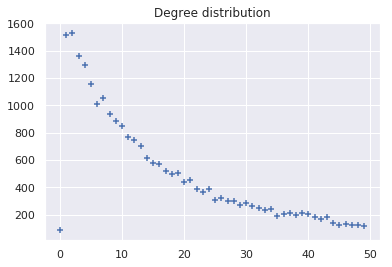

In [92]:
plt.scatter(degrees.index[:50], degrees.values[:50], marker='+')
plt.title('Degree distribution')

###### Nodes not connected

In [93]:
degrees[0]

86

###### Highest degree

In [100]:
degrees.index.max()

2346

# Node information analysis

In [112]:
node_information = load_data('node_information')

###### Publication date

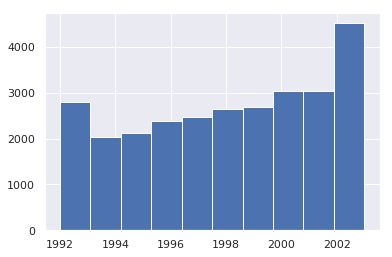

In [123]:
node_information.publication_date.hist()

In [129]:
node_information.publication_date.value_counts().sort_index()

1992    1112
1993    1687
1994    2044
1995    2114
1996    2395
1997    2479
1998    2647
1999    2696
2000    3040
2001    3038
2002    3335
2003    1183
Name: publication_date, dtype: int64

###### Missing date

In [128]:
node_information.publication_date.isna().value_counts()

False    27770
Name: publication_date, dtype: int64

###### Missing authors

In [127]:
node_information.authors.isna().value_counts()

False    23737
True      4033
Name: authors, dtype: int64

###### Authors per paper distribution

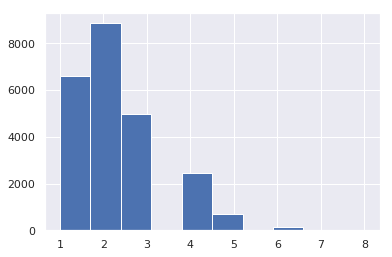

In [132]:
authors_per_paper = node_information.authors.dropna().apply(lambda x: len(x.split(',')))
authors_per_paper.hist()

###### Max authors per paper

In [137]:
authors_per_paper.max()

8

###### Number of authors

In [166]:
_authors = node_information.authors.dropna().apply(lambda x: x.split(','))

In [167]:
authors = []
for i, row in _authors.iteritems():
    for author in row:
        authors.append(author.strip())
authors = pd.Series(authors)

In [189]:
(lambda x: 'C. Ekstr' in x if x is not None else False)(None)

False

###### Extracting authors

In [445]:
def extract_authors(authors):
    stopwords = ['alex', 't', 'latex', 'pages', 'jr', 's']
    if isinstance(authors, str):
        
        # Remove string between parenthesis
        string = re.sub(r'\([^\)]+[\)$]','',authors)
        # Remove bad parenthesis
        string = re.sub(r'\([^\)]*$','', string)
        # Remove multiple spaces
        string = re.sub(r'\s', '', string)
        # Extract authors and sanityze strings
        
        authors = []
        for author in string.split(','):
            author = author.lower()
            author = re.sub(r'[\W\d]','', author).lower()
            if len(author) >= 2 and not author in stopwords:
                authors.append(author)
        return authors

In [446]:
_authors = node_information.authors.apply(lambda x : extract_authors(x))

In [447]:
authors = []
for x in _authors.values:
    if x:
        authors.extend(x)
authors = pd.Series(authors).value_counts()

###### Number of authors

In [450]:
authors.shape

(11456,)

###### Max quoted 

In [451]:
authors.max()

126

In [11]:
import pyspark.sql.functions as F

from pyspark.context import SparkContext
from pyspark.sql.context import SparkSession
sc = SparkContext()
spark = SparkSession(sc)


df = spark.createDataFrame(data=train)